## GEOCODING: API call + spatial join, or merge on names?

In [2]:
import pandas as pd
import geopandas as gpd # pip install geopandas
import json
from pandas import json_normalize
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from requests.structures import CaseInsensitiveDict

import numpy as np
import mapclassify # pip install mapclassify
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
import re
import ast

#conda install -c conda-forge cartopy
#then
#!pip install cartopy
#then
#pip install geoviews
# https://github.com/SciTools/cartopy/issues/1940#issuecomment-1303377066

#pd.set_option('display.max_rows', 500)

/tmp/ipykernel_603/1588768442.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# Read in the processed dataframe
alltext = pd.read_csv("alltext-no-engagement-sentimet.csv", sep = ";")
#fbtext = pd.read_csv("updated_articles_w_engangement.csv", sep = ";")
len(alltext)

13066

In [8]:
alltext = fbtext

In [5]:
GPE_tags = []

# loop through the dataframe 
for n in range(len(alltext)):
    try:
        # strip all unnecessary punctuation from the NER column
        stripped = ast.literal_eval(alltext['ner'][n].strip(']['))
        # append index number to list to keep track of rows 
        GPE_tags.append(n)
        
         # loop over the punctuation free NER tags
        for y in range(len(stripped)):
            try: 
                # Store all NER tags with GPE tag to only store location names
                gpe = stripped[y]['ents'].get("GPE")
                GPE_tags.append(gpe) # Append location names to list 
            except:
                pass # Ignore any entries without GPE tags 
        
    except SyntaxError as e:
        print(f"Error processing row, no NER tags {n}: {e}")
        GPE_tags.append(n)
        
        continue

Error processing row, no NER tags 64: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 691: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 747: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 998: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 1409: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 1417: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 1615: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 1758: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 2149: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 2292: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 2298: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 2554: invalid syntax (<unknown>, line 0)
Error processing row, no NER tags 2639: invalid syntax (<unknown>, line 0)
Error processing row, no NER t

In [6]:
# using list comprehension
# to remove None values in list
res = [i for i in GPE_tags if i is not None]
res[698:710] #spot check

[['Manly'],
 63,
 ['Colombia'],
 ['Supatá'],
 ['Colombia', 'Supatá'],
 ['Colombia'],
 ['Colombia'],
 64,
 65,
 ['Mauritius'],
 ['Mauritius'],
 ['Mauritius']]

In [7]:
# Define an empty dictionary
result_dict = {}

# Define key as None
key = None

# Loop through res list to identify int objects and assign as key for dict
for item in res:
    if isinstance(item, int):
        key = item
        result_dict[key] = []
    # assign the  location names as the values of the dictionary 
    else:
        for country in item:
            country = country.lower()
            if country not in result_dict[key]: # we only want a country name counted once per article 
                result_dict[key].append(country) # method is not perfect as a country may be named differently in the same article so it is not counted as a duplicate
        
len(result_dict)

13066

In [8]:
# spot check
result_dict[63]

['colombia', 'supatá']

In [9]:
# turn the dictionary into a dataframe 
geolocations =  pd.DataFrame(pd.Series(result_dict))
geolocations = geolocations.rename(columns = {0:"locations"})
len(geolocations)

13066

In [10]:
geolocations['strng'] = geolocations['locations'].apply(lambda x : ', '.join(x))
geolocations

,locations,strng
0,"[east lampung, lampung province, satria, jalu,...","east lampung, lampung province, satria, jalu, ..."
1,"[lampung, jakarta, tempo.co, east lampung, lam...","lampung, jakarta, tempo.co, east lampung, lamp..."
2,"[cambodia, phnom penh, new york, koh kong, tha...","cambodia, phnom penh, new york, koh kong, thai..."
3,"[nairobi, sudan, indonesia, pejeta, zoo, the c...","nairobi, sudan, indonesia, pejeta, zoo, the cz..."
4,"[cikepuh, sukabumi, west java, tempo.co, jakarta]","cikepuh, sukabumi, west java, tempo.co, jakarta"
...,...,...
13061,"[ball, new orleans]","ball, new orleans"
13062,"[odisha, india, sipakuda, satapada]","odisha, india, sipakuda, satapada"
13063,"[shivamogga, sagara, kulem, madgaon]","shivamogga, sagara, kulem, madgaon"
13064,[amazonia],amazonia


In [12]:
# pip install country-named-entity-recognition
from country_named_entity_recognition import find_countries
# https://fastdatascience.com/country-named-entity-recognition/

countries_id = []
for i in geolocations["strng"]:
    counts = []
    result = find_countries(i, is_ignore_case=True)
    for n in range(len(result)):
        name = result[n][0].name
        iso3 = result[n][0].alpha_3
        counts.append((name, iso3))
        
    countries_id.append(counts)
    
len(countries_id)


13066

In [13]:
# create dataframe from list of gathered countries and iso codes 
temp = pd.DataFrame({"Countries":countries_id})
# Concatenate with the dataframe 
df_nw = pd.concat([alltext, temp], axis = 1)

# check daatframe
df_nw.head()

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class,Order,Family,Genus,...,NativeDistributionFullNames,Extinct_Distribution,text,title,link,image,date,ner,sentiment,Countries
0,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,"Bangladesh,Cambodia,India,Indonesia,Lao People...",NaN,"TEMPO.CO, East Lampung - President Joko Widodo...",Jokowi Names Sumatran Rhino `Delilah`,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, East Lampung - President ...",Positive,[]
1,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,"Bangladesh,Cambodia,India,Indonesia,Lao People...",NaN,"TEMPO.CO, Jakarta - Holding a huge appeal for ...",Lampung Holds Huge Appeal for International To...,https://news.google.com/articles/CBMiU2h0dHA6L...,https://statik.tempo.co/data/2015/02/01/id_366...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Holding a huge ...",Positive,[]
2,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,Indonesia,NaN,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,"[{'sent': ""TEMPO.CO, Phnom Penh - Wildlife res...",Positive,"[(Cambodia, KHM), (Thailand, THA), (Malaysia, ..."
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,Indonesia,NaN,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,"[{'sent': 'TEMPO.CO, Nairobi - The world`s las...",Negative,"[(Sudan, SDN), (Indonesia, IDN), (Czechia, CZE..."
4,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,Indonesia,NaN,"TEMPO.CO, Jakarta - A Javan Leopard (Panthera ...",Javan Leopard Spotted in West Java Conservatio...,https://news.google.com/articles/CBMiVGh0dHBzO...,https://statik.tempo.co/data/2016/03/31/id_494...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - A Javan Leopard...",Negative,[]


### Only for articles with FB shares

In [101]:

# Only keep articles with shares
shared = df_nw.loc[df_nw['shares'] > 0].reset_index(drop = True)

# Define a binary classification in a new column for popularity
shared['Popular'] = 0

# Loop over the values in the shares column and if above the median classify as popular
for x in shared["shares"]:
    if x > shared["shares"].mean():
        shared.loc[shared['shares'] == x, 'Popular'] = 1

In [91]:
pd.DataFrame(df_nw.groupby('scientific_name')["shares"].sum()).reset_index()

,scientific_name,shares
0,Abies guatemalensis,1396.0
1,Abronia campbelli,31.0
2,Acerodon jubatus,5304.0
3,Aceros nipalensis,40.0
4,Acinonyx jubatus,15032.0
...,...,...
556,Vini ultramarina,0.0
557,Vipera ursinii,308.0
558,Vultur gryphus,2674.0
559,Xanthopsar flavus,0.0


In [102]:
#shared = shared.loc[shared['Popular'] == 1]
s = shared.explode('Countries').groupby(['scientific_name'])['Countries'].value_counts()

s = pd.DataFrame(s).rename(columns = {'Countries': "mentions"}).reset_index()

# Store as temp df with share count stored 
#x = pd.DataFrame(df_nw.groupby('scientific_name')["shares"].sum()).reset_index()

# Create df of how many rows per species (AKA how many articles)
#x = df_nw['scientific_name'].value_counts()
# Store as temp df
#x = pd.DataFrame(x).reset_index().rename(columns = {'index':'scientific_name', 'scientific_name': 'article_cnt'})


#country_cnt = s.merge(x, on = 'scientific_name')

In [104]:
s.to_csv("csv/sharedmorethan1_countryMentions.csv", sep = ";", index = False)

In [21]:
s = pd.read_csv("csv/sharedmorethan1_countryMentions.csv", sep = ";")
s

,scientific_name,Countries,mentions
0,Abies guatemalensis,"('Mexico', 'MEX')",2
1,Abies guatemalensis,"('Canada', 'CAN')",1
2,Abies guatemalensis,"('Guatemala', 'GTM')",1
3,Abronia campbelli,"('Costa Rica', 'CRI')",1
4,Abronia campbelli,"('Guatemala', 'GTM')",1
...,...,...,...
7788,Vultur gryphus,"('Switzerland', 'CHE')",1
7789,Vultur gryphus,"('United Kingdom', 'GBR')",1
7790,Zosterops albogularis,"('Australia', 'AUS')",1
7791,Zosterops albogularis,"('New Zealand', 'NZL')",1


### Merging dataframes

In [3]:
speciesinfo = pd.read_csv("csv/fullspeciesinfo.csv", sep = ";")

In [25]:
# Explode the lists in the Countries column so each species has one row dedicated per country
# storing value counts so we have a count of how many times a country is mentioned per species
# countries only counted once per article as per earlier comment
t = df_nw.explode('Countries').groupby(['scientific_name'])['Countries'].value_counts()

# create csv
#t.to_csv("csv/countryNER_final.csv", sep = ';')

t = pd.DataFrame(t).rename(columns = {'Countries': "mentions"}).reset_index()

# Create df of how many rows per species (AKA how many articles)
y = df_nw['scientific_name'].value_counts()
# Store as temp df
y = pd.DataFrame(y).reset_index().rename(columns = {'index':'scientific_name', 'scientific_name': 'article_cnt'})

country_cnt_1 = t.merge(y, on = 'scientific_name')
country_cnt_1

,scientific_name,Countries,mentions,article_cnt
0,Abies guatemalensis,"(Guatemala, GTM)",4,4
1,Abies guatemalensis,"(Canada, CAN)",2,4
2,Abies guatemalensis,"(Mexico, MEX)",2,4
3,Abies guatemalensis,"(Colombia, COL)",1,4
4,Abies guatemalensis,"(Denmark, DNK)",1,4
...,...,...,...,...
10885,Xanthopsar flavus,"(Argentina, ARG)",1,2
10886,Xanthopsar flavus,"(Brazil, BRA)",1,2
10887,Zosterops albogularis,"(Australia, AUS)",2,3
10888,Zosterops albogularis,"(New Zealand, NZL)",1,3


In [28]:
temp = country_cnt_1.merge(speciesinfo[['scientific_name', 'Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species']],
                  on = "scientific_name", how = "left")

In [30]:
temp

,scientific_name,Countries,mentions,article_cnt,Kingdom,Class,Order,Family,Genus,Species
0,Abies guatemalensis,"(Guatemala, GTM)",4,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis
1,Abies guatemalensis,"(Canada, CAN)",2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis
2,Abies guatemalensis,"(Mexico, MEX)",2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis
3,Abies guatemalensis,"(Colombia, COL)",1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis
4,Abies guatemalensis,"(Denmark, DNK)",1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis
...,...,...,...,...,...,...,...,...,...,...
10885,Xanthopsar flavus,"(Argentina, ARG)",1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus
10886,Xanthopsar flavus,"(Brazil, BRA)",1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus
10887,Zosterops albogularis,"(Australia, AUS)",2,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis
10888,Zosterops albogularis,"(New Zealand, NZL)",1,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis


In [32]:
# Create a copy of the dataframe
df = temp.copy()
# Separate the Countries column into country and iso3 columns respectively 
df[['country', 'iso3']] = pd.DataFrame(df['Countries'].tolist())
df = df.drop('Countries',axis=1)
df

,scientific_name,mentions,article_cnt,Kingdom,Class,Order,Family,Genus,Species,country,iso3
0,Abies guatemalensis,4,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Guatemala,GTM
1,Abies guatemalensis,2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Canada,CAN
2,Abies guatemalensis,2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Mexico,MEX
3,Abies guatemalensis,1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Colombia,COL
4,Abies guatemalensis,1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Denmark,DNK
...,...,...,...,...,...,...,...,...,...,...,...
10885,Xanthopsar flavus,1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus,Argentina,ARG
10886,Xanthopsar flavus,1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus,Brazil,BRA
10887,Zosterops albogularis,2,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis,Australia,AUS
10888,Zosterops albogularis,1,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis,New Zealand,NZL


In [33]:
df.to_csv("csv/alltext_speciesinfo_countries.csv", sep = ";", index = False)

## Creating Maps

In [3]:
df = pd.read_csv("csv/alltext_speciesinfo_countries.csv", sep = ";")
df

,scientific_name,mentions,article_cnt,Kingdom,Class,Order,Family,Genus,Species,country,iso3
0,Abies guatemalensis,4,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Guatemala,GTM
1,Abies guatemalensis,2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Canada,CAN
2,Abies guatemalensis,2,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Mexico,MEX
3,Abies guatemalensis,1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Colombia,COL
4,Abies guatemalensis,1,4,Plantae,NaN,Pinales,Pinaceae,Abies,guatemalensis,Denmark,DNK
...,...,...,...,...,...,...,...,...,...,...,...
10885,Xanthopsar flavus,1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus,Argentina,ARG
10886,Xanthopsar flavus,1,2,Animalia,Aves,Passeriformes,Icteridae,Xanthopsar,flavus,Brazil,BRA
10887,Zosterops albogularis,2,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis,Australia,AUS
10888,Zosterops albogularis,1,3,Animalia,Aves,Passeriformes,Zosteropidae,Zosterops,albogularis,New Zealand,NZL


In [4]:
# Read in globe shapefile dataframe 
world = gpd.read_file("shapefiles/TM_WORLD_BORDERS-0.3.shp")
#world_1 = gpd.read_file("shapefiles/World_Countries__Generalized_.shp")
# Read in the dataframe with gpe info 
#gpe = pd.read_csv("csv/speciesinfo_gpetags.csv", sep = ";")

In [5]:
# Groupby iso3 column in order to merge with shapefile
allmentions = df.groupby("iso3")['mentions'].sum().sort_values(ascending = False).reset_index()
#allshares = df.groupby("iso3")['shares'].sum().sort_values(ascending = False).reset_index()
# Merge on iso3 code 
mentionsgdf = pd.merge(allmentions, world, left_on=allmentions["iso3"], right_on=world["ISO3"], how="right").drop(columns = "key_0")
#mentionsgdf = pd.merge(allshares, world, left_on=allmentions["iso3"], right_on=world["ISO3"], how="right").drop(columns = "key_0")
# Redefine as a geodataframe
mentionsgdf = gpd.GeoDataFrame(mentionsgdf, geometry='geometry')




# Visualizations for articles tagged with Aves 
birds = df.loc[df['Class'] == "Aves"].reset_index(drop = True)
birdsmentions = birds.groupby("iso3")['mentions'].sum().sort_values(ascending = False).reset_index()
birdsgdf = pd.merge(birdsmentions, world, left_on=birdsmentions["iso3"], right_on=world["ISO3"], how="right").drop(columns = "key_0")
# Redefine as a geodataframe
birdsgdf = gpd.GeoDataFrame(birdsgdf, geometry='geometry')


# Mammal articles
mammals = df.loc[df['Class'] == "Mammalia"].reset_index(drop = True)
mammentions = mammals.groupby("iso3")['mentions'].sum().sort_values(ascending = False).reset_index()
mammalsgdf = pd.merge(mammentions, world, left_on=mammentions["iso3"], right_on=world["ISO3"], how="right").drop(columns = "key_0")
# Redefine as a geodataframe
mammalsgdf = gpd.GeoDataFrame(mammalsgdf, geometry='geometry')


# Reptile articles
reptiles = df.loc[df['Class'] == "Reptilia"].reset_index(drop = True)
repsmentions = reptiles.groupby("iso3")['mentions'].sum().sort_values(ascending = False).reset_index()
reptilesgdf = pd.merge(repsmentions, world, left_on=repsmentions["iso3"], right_on=world["ISO3"], how="right").drop(columns = "key_0")
# Redefine as a geodataframe
reptilesgdf = gpd.GeoDataFrame(reptilesgdf, geometry='geometry')


In [36]:
# How many countries not mentioned in the articles; their iso3 values from df will be blank
mentionsgdf['iso3'].isnull().sum()

34

In [37]:
# Another join this time inner to investigate what countries are not successfully joined to shaepfiles
inner_temp = pd.merge(allmentions, world, left_on=allmentions["iso3"], right_on=world["ISO3"], how="inner").drop(columns = "key_0")

iso3_inner = inner_temp['iso3'].unique()
iso3_all = allmentions['iso3'].unique()

print("The countries left behind:", list(set(iso3_all) - set(iso3_inner)))

The countries left behind: ['CUW', 'BES', 'SSD']


In [123]:
#mentionsgdf.to_file("shapefiles/accurate_country_mentions.shp")

/tmp/ipykernel_603/2744410731.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PuRd', 7)


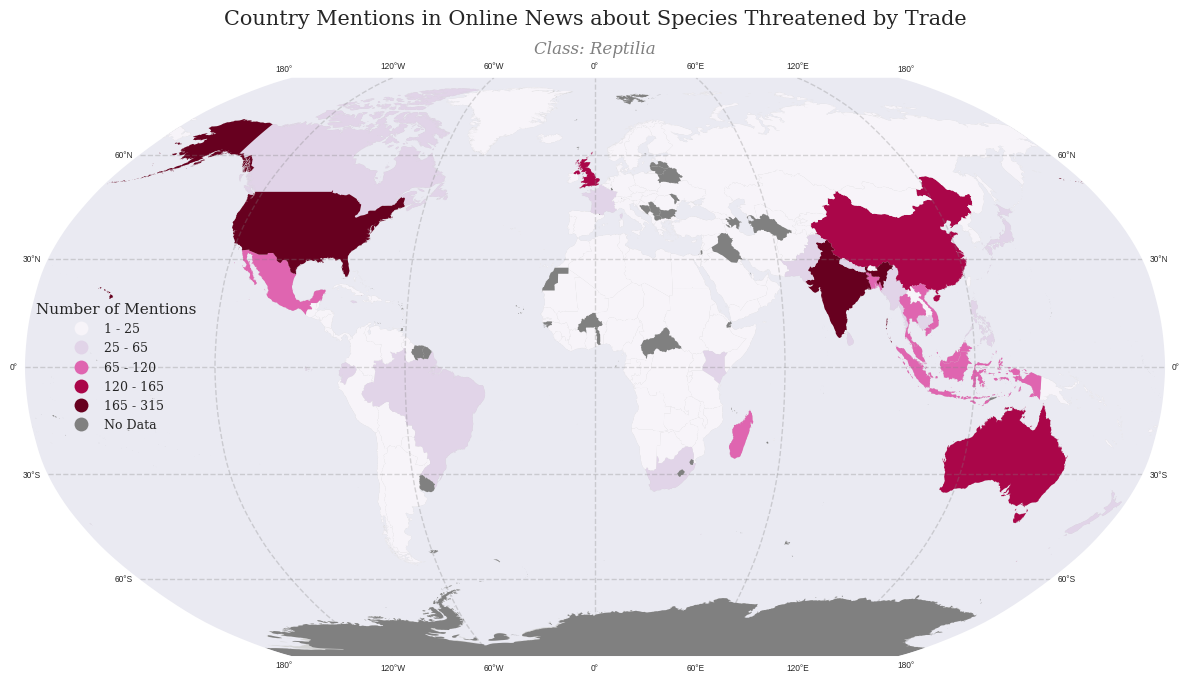

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Convert GeoDataFrame to Robinson projection
robinson = ccrs.Robinson()
# Change to necessary DF (birds, mammals, reptiles, etc)
mentionsgdf_robinson = reptilesgdf.to_crs(robinson.proj4_init)

# Create figure and axis with Robinson projection
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.Robinson()})

# Add land mask and gridlines
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.xlabel_style = {'fontsize': 6}
gl.ylabel_style = {'fontsize': 6}


# Define color map and how many bins needed
cmap = plt.cm.get_cmap('PuRd', 7)
# Any countries with NaN values will be colored grey
missing_kwds = dict(color='grey', label='No Data')

# Classification scheme options: EqualInterval, Quantiles, NaturalBreaks, UserDefined etc.
mentionsgdf_robinson.plot(column='mentions', 
                 scheme='UserDefined',
                 #classification_kwds = {'bins':[10, 50, 200, 500, 1000, 2000, 2500]}, 
                 classification_kwds = {'bins':[25, 65, 120, 165, 315]}, 
                 cmap = cmap, 
                 legend=True, 
                 legend_kwds=({"loc":'center left', 'title': 'Number of Mentions', 'prop': {'size': 9, 'family': 'serif'}}),
                 missing_kwds=missing_kwds,
                 ax=ax,
                 )

# Define the bounds of the classification scheme
upper_bounds = mapclassify.UserDefined(mentionsgdf.mentions, bins=[25, 65, 120, 165, 315]).bins
                                       #bins=[10, 50, 200, 500, 1000, 2000, 2500]).bins
#upper_bounds = mapclassify.NaturalBreaks(mentionsgdf.shares, k = 5).bins

bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = mentionsgdf.mentions.min()
    else:
        lower_bound = upper_bounds[index-1]

    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)


# replace the legend title and increase font size
legend_title = ax.get_legend().get_title()
legend_title.set_fontsize(11)
legend_title.set_family('serif')

# get all the legend labels and increase font size
legend_labels = ax.get_legend().get_texts()
# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
       legend_label.set_text(bound)
    

# Add suptitle above the title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Country Mentions in Online News about Species Threatened by Trade", fontsize=15, family = 'Serif')
plt.subplots_adjust(top=1.20)
ax.set_title("Class: Reptilia", 
             fontsize = 12, color="grey", style='italic', family = 'Serif')

plt.savefig('figures/worldmap_mentions_reptiles.png')

### Necessary only for retrieving Point data

In [ ]:
country_count['Countries'].sort_values().unique()

In [ ]:
# For retrieveing the Point data from the country names in the dataframe
# Create an empty list for storing the json responses
locs = []

# Loop through the country names in the dataframe 
for text in gpe['Countries'].unique():
    # Limiting to 1 result returns the most likely possibility, the country location 
    url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&type=country&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    resp = requests.get(url, headers=headers)
    
    try:
        locs.append(resp.json()['features'][0]['properties'])
    except IndexError: 
        url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
        headers = CaseInsensitiveDict()
        headers["Accept"] = "application/json"

        resp = requests.get(url, headers=headers)
        locs.append(resp.json()['features'][0]['properties'])


In [ ]:
test = []
# Loop over the list with json responses of country name and geodata
for n in range(len(locs)):
    # Store the geometry and name of each response into a dictionary
    geom = {'geometry' : (locs[n]['lon'], locs[n]['lat'])}
    name = {'name' : locs[n]['formatted']}
    
    # loop over both dictionaries simultaneously and store the result into a tuple
    # to then append to the empty list that was previously defined 
    for g, n in zip(geom, name):
        t = (name[n], geom[g])
        test.append(t)
        
# Create a dataframe from the list       
geom = pd.DataFrame(test, columns =['Countries', 'geometry'])

In [ ]:
from shapely.geometry import Point
# apply Shapely Point to turn tuples into coordinates
geom['Coordinates'] = geom['geometry'].apply(lambda x: Point(x))
# Create a geodataframe from the pandas dataframe
gdf = gpd.GeoDataFrame(geom, geometry="Coordinates")
gdf = gdf.set_crs('epsg:4326')

In [ ]:
# Spatial join between the point data and ready polygon data of countries 
globeshps = world.sjoin(gdf, how="left", predicate='contains').reset_index(drop = True).drop(columns = "geometry_right")

In [ ]:
geospecies.loc[geospecies['geometry'].isnull()]['Countries_x'].unique()

#### Processing and Joining 

In [ ]:
# Finding the top country for each species (according to text mentions of that country in each species' article) and keeping only those rows
topspecies_country = gpe.loc[gpe.groupby("scientific_name")['mentions_country'].idxmax()].reset_index(drop = True)

# Counting how many species each country is listed as the top one
topcountries = topspecies_country.groupby(topspecies_country["Countries"].tolist(),as_index=False)\
            .size().sort_values(by="size", ascending = False).reset_index(drop = True)

# Rename columns more intuitvely
topcountries = topcountries.rename(columns = {'index' : 'Country', 'size' : 'species_count'})
# Manual change of country name to match to shapefiles
topcountries['Country'] = topcountries['Country'].str.replace("russia", "russian federation")

In [ ]:
# merge the dataframes on their names 
topstateshp = pd.merge(topcountries, world, left_on=topcountries["Country"], right_on=world["COUNTRY"].str.lower(),\
                       how="right").drop(columns = "key_0")
# re-establish that it is a geodataframe
topstates_shp = gpd.GeoDataFrame(topstateshp, geometry='geometry')

In [ ]:
## ONLY FOR SPATIAL JOIN
world_gpe = world.sjoin(gdf, how="inner", predicate='contains').reset_index(drop = True)

df = (world_gpe.groupby(['COUNTRY','FID'])
      .agg({'sci_name': lambda x: x.tolist(),'txt_mentions':'sum','article_co':'sum'})
      .rename({'txt_mentions' : 'Sum_txt_mentns','article_co' : 'Sum_articles'},axis=1)
      .reset_index())

df['species_num'] = df['sci_name'].str.len()

sample_map = df.merge(world, on = 'FID', how = 'left')
geosample = gpd.GeoDataFrame(sample_map, geometry='geometry')

In [ ]:
# Sample map
#topstates_shp.plot(topstates_shp['species_count'], legend = True, figsize = (12,5), )
fig, ax = plt.subplots(figsize=(12, 10))

cmap = plt.cm.get_cmap('YlOrRd', 5)
missing_kwds = dict(color='grey', label='No Data')

topstates_shp.plot(column='species_count', scheme='NaturalBreaks', k= 5, cmap = cmap,
         legend=True, legend_kwds=dict(loc='center left'),
         missing_kwds=missing_kwds, ax=ax)

# Add suptitle above the title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Species Count by Country", fontsize=15, family = 'Serif')
plt.subplots_adjust(top=1.26)
ax.set_title("Most frequently mentioned countries of each species' news articles", \
             fontsize = 10, color="grey", style='italic', family = 'Serif')

#plt.savefig('figures/temp.png')

In [ ]:
gpe.groupby(["scientific_name"])['sharecount'].sum().sort_values(ascending = False).reset_index()

In [ ]:
# Similar visualziation but this time aggregating all country mentions in the articles 
allmentions = gpe.groupby("Countries")['mentions_country'].sum().sort_values(ascending = False).reset_index()
# Naming conventions different, manual change
allmentions['Countries'] = allmentions['Countries'].str.replace("russia", "russian federation")

# Merge on country name after temporarily lowering the case of the names in the world gdf
mentionsgdf = pd.merge(allmentions, world, left_on=allmentions["Countries"], right_on=world["COUNTRY"]\
                       .str.lower(), how="right").drop(columns = "key_0")

# Redefine as a geodataframe
mentionsgdf = gpd.GeoDataFrame(mentionsgdf, geometry='geometry')

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Convert GeoDataFrame to Robinson projection
robinson = ccrs.Robinson()
mentionsgdf_robinson = mentionsgdf.to_crs(robinson.proj4_init)

# Create figure and axis with Robinson projection
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.Robinson()})

# Add land mask and gridlines
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.xlabel_style = {'fontsize': 6}
gl.ylabel_style = {'fontsize': 6}


# Define color map and how many bins needed
cmap = plt.cm.get_cmap('YlOrRd', 7)
# Any countries with NaN values will be colored grey
missing_kwds = dict(color='grey', label='No Data')

# Classification scheme options: EqualInterval, Quantiles, NaturalBreaks, UserDefined etc.
mentionsgdf_robinson.plot(column='mentions_country', 
                 scheme='UserDefined', 
                 classification_kwds = {'bins':[10, 50, 200, 500, 1000, 2000, 2702]}, 
                 cmap = cmap, 
                 legend=True, 
                 legend_kwds=({"loc":'center left', 'title': 'Number of Mentions', 'prop': {'size': 9, 'family': 'serif'}}),
                 missing_kwds=missing_kwds,
                 ax=ax,
                 )

# Define the bounds of the classification scheme
upper_bounds = mapclassify.UserDefined(mentionsgdf.mentions_country, 
                                       bins=[10, 50, 200, 500, 1000, 2000, 2702]).bins

bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = mentionsgdf.mentions_country.min()
    else:
        lower_bound = upper_bounds[index-1]

    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)


# replace the legend title and increase font size
legend_title = ax.get_legend().get_title()
legend_title.set_fontsize(11)
legend_title.set_family('serif')

# get all the legend labels and increase font size
legend_labels = ax.get_legend().get_texts()
# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    

# Add suptitle above the title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Country Mentions in Online News about Species Threatend by Trade", fontsize=15, family = 'Serif')
plt.subplots_adjust(top=1.23)
#ax.set_title("Sum of mentions of countries in the dataset", 
             #fontsize = 10, color="grey", style='italic', family = 'Serif')

plt.savefig('figures/worldmap_mentions.png')

#### Failed Attempts - DO NOT RUN

In [ ]:
# read in dataframe of countrynames with all relevant aliases (No Guatemala for some reason)
countrynames = pd.read_csv("csv/country-aliases.csv", sep = ",")
countrynames['Alias'] = countrynames['Alias'].str.lower()
aliases = list(countrynames['Alias'])


# Rename column for later merging
countrynames = countrynames.rename(columns = {'Alias':'Countries'})
countrynames.head(10)

nameswaliases = pd.merge(countries, countrynames, on = 'iso3', how = 'left')

In [ ]:
# Obtained from https://stackoverflow.com/questions/59444065/differentiate-between-countries-and-cities-in-spacy-ner/59458133#59458133
# Alternative way to get countries but some are left out due to differences in naming 
import geonamescache
# pip install geonamescache
gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()



def gen_dict_extract(var, key):
    if isinstance(var, dict):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, (dict, list)):
                yield from gen_dict_extract(v, key)
    elif isinstance(var, list):
        for d in var:
            yield from gen_dict_extract(d, key)
            
names = [*gen_dict_extract(countries, 'name')]
names = [txt.lower() for txt in names]
iso3 = [*gen_dict_extract(countries, 'iso3')] 


# create dataframe from names and iso codes 
countries = pd.DataFrame(
    {'names': names,
     'iso3': iso3,
    })

In [ ]:
# define an empty list
new = []

for i in geolocations["locations"]:
   # print(geolocations.loc[geolocations["locations"] == i]) 
    counts = []
    # loop through the location names and match to the countries                                    
    for y in i:
        if y in countries: #or aliases
            counts.append(y)
     
    # append to empty list
    new.append(counts)

# ensure that the length of new list is identical to original dataframe
len(new)

In [ ]:
# define a matching function using fuzzy matching
def match_location(row):
    matches = []
    for location in row['locations']:
        
        if pd.notnull(location) and isinstance(location, str):
            for name, aliases in zip(nameswaliases['names'], nameswaliases['Countries']):
                # check if the location exactly matches a country name or alias
                if location == name or (pd.notnull(aliases) and location in aliases):
                    matches.append(nameswaliases.loc[nameswaliases['names'] == name, 'iso3'].iloc[0])
                else:
                    # check for fuzzy matches with a minimum score of 90
                    if pd.notnull(aliases):
                        match_scores = [fuzz.token_set_ratio(location, alias) for alias in aliases]
                        if any(score > 90 for score in match_scores):
                            matches.append(nameswaliases.loc[nameswaliases['names'] == name, 'iso3'].iloc[0])
            if len(matches) > 0:
                return matches
            else:
                return None

# apply the matching function to each row of the geolocations dataframe
geolocations['matches'] = geolocations.apply(match_location, axis=1)

# append the iso3 codes to a list
new = []
for matches in geolocations['matches']:
    if matches is not None:
        new.extend(matches)
    else:
        new.append(None)

In [ ]:
from thefuzz import fuzz
import Levenshtein

# define an empty list
new = []

# loop through the location names
for loc_names in geolocations["locations"]:
    counts = []
    
    # loop through the countries
    for name in nameswaliases['names']:
        
        # loop through the location names and compare each one with the country name using fuzzy matching
        for loc_name in loc_names:
            match_score = fuzz.token_set_ratio(name, loc_name)
            
            # if the match score is above a certain threshold, consider it a match
            if match_score > 90:
                counts.append(nameswaliases.loc[nameswaliases["Countries"] == name]['iso3'].unique().item())
                
            else:
                for alias in nameswaliases['Countries']:
                    match_score = fuzz.token_set_ratio(alias, loc_name)
            
                    # if the match score is above a certain threshold, consider it a match
                    if match_score > 90:
                        counts.append(nameswaliases.loc[nameswaliases["Countries"] == alias]['iso3'].unique().item())
                        break
                break  # break out of the inner loop once a match is found for this country
    
    # append to empty list
    new.append(counts)

In [ ]:
from thefuzz import fuzz
import Levenshtein

# define an empty list
new = []

# loop through the location names
for loc_names in geolocations["locations"]:
    counts = []
    
    # loop through the countries
    for country in countries:
        
        # loop through the location names and compare each one with the country name using fuzzy matching
        for loc_name in loc_names:
            match_score = fuzz.token_set_ratio(country, loc_name)
            
            # if the match score is above a certain threshold (e.g., 70), consider it a match
            if match_score > 90:
                counts.append(country)
                break  # break out of the inner loop once a match is found for this country
    
    # append to empty list
    new.append(counts)
    
len(new)

In [ ]:
# create a function to map country names to iso codes
# for use only with country aliases
def map_country_to_iso(country_names):
    iso_codes = []
    for country_name in country_names:
        # get iso code from countrynames df
        iso_code = countrynames.loc[countrynames['Countries'] == country_name, 'iso3'].iloc[0]
        # append iso code to list if it's not already present
        if iso_code not in iso_codes:
            iso_codes.append(iso_code)
    return iso_codes

# apply the function to the country_names column of df1 to create a new column of iso codes
loc_df['iso3'] = loc_df['Countries'].apply(map_country_to_iso)

In [ ]:
# Save to csv for geocoding in other notebook
country_count.to_csv("csv/speciesinfo_updated_gpetags.csv", sep = ';', index = False)